In [ ]:
# VGG16 in PyTorch
import os
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths
traindir = r"C:\Users\HP-OMEN\OneDrive\Desktop\crop disease\train"
validdir = r"C:\Users\HP-OMEN\OneDrive\Desktop\crop disease\valid"

# Image transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
train_dataset = datasets.ImageFolder(traindir, data_transforms['train'])
valid_dataset = datasets.ImageFolder(validdir, data_transforms['valid'])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, prefetch_factor=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=4, prefetch_factor=2, pin_memory=True)

# Define the model
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

# Modify classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.BatchNorm1d(4096),
    nn.Linear(4096, 38),
    nn.Softmax(dim=1)
)

model = model.to(device)

# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train and evaluate function
def train_model(model, criterion, optimizer, scheduler, num_epochs=8, save_path='best_vgg16_model.pth'):
    best_acc = 0.0
    train_loss, valid_loss, train_acc, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            correct += torch.sum(preds == labels)
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct.double() / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc.cpu())

        # Validation phase
        model.eval()
        running_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                correct += torch.sum(preds == labels)
                total += labels.size(0)

        valid_loss_epoch = running_loss / len(valid_loader.dataset)
        valid_acc_epoch = correct.double() / total
        valid_loss.append(valid_loss_epoch)
        valid_acc.append(valid_acc_epoch.cpu())
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Valid Loss: {valid_loss_epoch:.4f} Acc: {valid_acc_epoch:.4f}')

        # Save the model if it has the best validation accuracy so far
        if valid_acc_epoch > best_acc:
            best_acc = valid_acc_epoch
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with accuracy: {best_acc:.4f}")

        scheduler.step()

    return train_loss, valid_loss, train_acc, valid_acc

# Run training
train_loss, valid_loss, train_acc, valid_acc = train_model(model, criterion, optimizer, scheduler)

# Save the final model
torch.save(model.state_dict(), 'final_vgg16_model.pth')
print("Final model saved as final_vgg16_model.pth")

# Plotting function
def plot_learning_curve(train_loss, valid_loss, train_acc, valid_acc):
    sns.set()
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, color='blue', label='Train Loss')
    plt.plot(valid_loss, color='orange', label='Valid Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, color='blue', label='Train Accuracy')
    plt.plot(valid_acc, color='orange', label='Valid Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

plot_learning_curve(train_loss, valid_loss, train_acc, valid_acc)


Epoch 1/10
Train Loss: 3.1501 Acc: 0.6432
Valid Loss: 2.8474 Acc: 0.8929
Epoch 2/10
Train Loss: 2.8420 Acc: 0.9038
Valid Loss: 2.7921 Acc: 0.9378
Epoch 3/10
Train Loss: 2.8062 Acc: 0.9343
Valid Loss: 2.7745 Acc: 0.9512
Epoch 4/10
Train Loss: 2.7937 Acc: 0.9439
Valid Loss: 2.7664 Acc: 0.9570
Epoch 5/10
Train Loss: 2.7876 Acc: 0.9504
Valid Loss: 2.7631 Acc: 0.9618
Epoch 6/10
Train Loss: 2.7841 Acc: 0.9564
Valid Loss: 2.7604 Acc: 0.9640
Epoch 7/10
Train Loss: 2.7839 Acc: 0.9586
Valid Loss: 2.7592 Acc: 0.9678
Epoch 8/10
Train Loss: 2.7809 Acc: 0.9612
Valid Loss: 2.7584 Acc: 0.9671
Epoch 9/10
Train Loss: 2.7807 Acc: 0.9608
Valid Loss: 2.7597 Acc: 0.9666
Epoch 10/10
Train Loss: 2.7806 Acc: 0.9614
Valid Loss: 2.7587 Acc: 0.9677


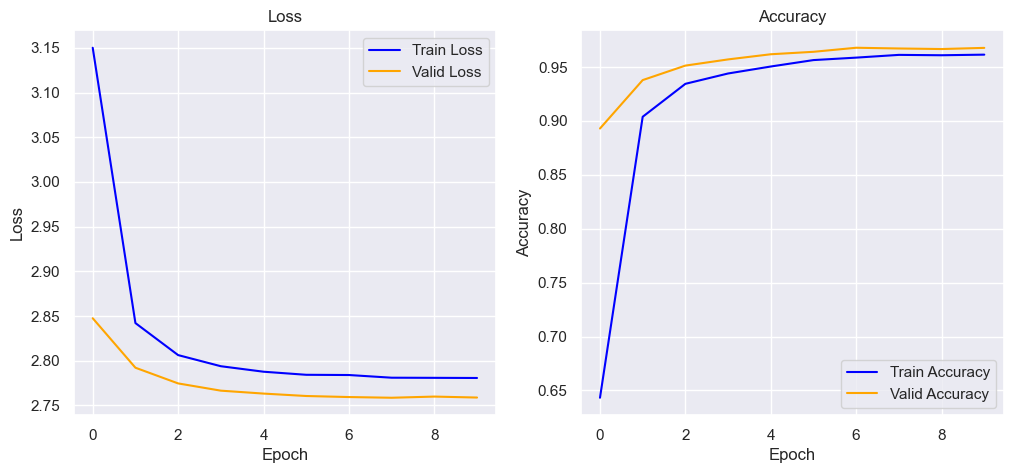

In [3]:
# EfficientNet-B0 in PyTorch
import os
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths
traindir = r"C:\Users\HP-OMEN\OneDrive\Desktop\crop disease\train"
validdir = r"C:\Users\HP-OMEN\OneDrive\Desktop\crop disease\valid"

# Image transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
train_dataset = datasets.ImageFolder(traindir, data_transforms['train'])
valid_dataset = datasets.ImageFolder(validdir, data_transforms['valid'])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=4)

# Load EfficientNet-B0 model
model = models.efficientnet_b0(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier layer for our specific number of classes
num_classes = 38
model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 4096),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.BatchNorm1d(4096),
    nn.Linear(4096, num_classes),
    nn.Softmax(dim=1)
)

model = model.to(device)

# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier[1].parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train and evaluate function
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    train_loss, valid_loss, train_acc, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            correct += torch.sum(preds == labels)
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct.double() / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc.cpu())

        # Validation phase
        model.eval()
        running_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                correct += torch.sum(preds == labels)
                total += labels.size(0)

        valid_loss_epoch = running_loss / len(valid_loader.dataset)
        valid_acc_epoch = correct.double() / total
        valid_loss.append(valid_loss_epoch)
        valid_acc.append(valid_acc_epoch.cpu())
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Valid Loss: {valid_loss_epoch:.4f} Acc: {valid_acc_epoch:.4f}')

        scheduler.step()

    return train_loss, valid_loss, train_acc, valid_acc

# Run training
train_loss, valid_loss, train_acc, valid_acc = train_model(model, criterion, optimizer, scheduler)

# Save the model
torch.save(model.state_dict(), "efficientnet_b0_plantdisease.pth")

# Plotting function
def plot_learning_curve(train_loss, valid_loss, train_acc, valid_acc):
    sns.set()
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, color='blue', label='Train Loss')
    plt.plot(valid_loss, color='orange', label='Valid Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, color='blue', label='Train Accuracy')
    plt.plot(valid_acc, color='orange', label='Valid Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

plot_learning_curve(train_loss, valid_loss, train_acc, valid_acc)


C:\Users\HP-OMEN\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\HP-OMEN/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:05<00:00, 2.68MB/s]


Epoch 1/8
Train Loss: 2.9630 Acc: 0.7964
Valid Loss: 2.7709 Acc: 0.9513
Epoch 2/8
Train Loss: 2.7793 Acc: 0.9522
Valid Loss: 2.7576 Acc: 0.9641
Epoch 3/8
Train Loss: 2.7731 Acc: 0.9597
Valid Loss: 2.7570 Acc: 0.9678
Epoch 4/8
Train Loss: 2.7738 Acc: 0.9647
Valid Loss: 2.7588 Acc: 0.9706
Epoch 5/8
Train Loss: 2.7794 Acc: 0.9658
Valid Loss: 2.7670 Acc: 0.9713
Epoch 6/8
Train Loss: 2.7883 Acc: 0.9655
Valid Loss: 2.7729 Acc: 0.9718
Epoch 7/8
Train Loss: 2.7996 Acc: 0.9649
Valid Loss: 2.7812 Acc: 0.9705
Epoch 8/8
Train Loss: 2.7954 Acc: 0.9676
Valid Loss: 2.7726 Acc: 0.9737


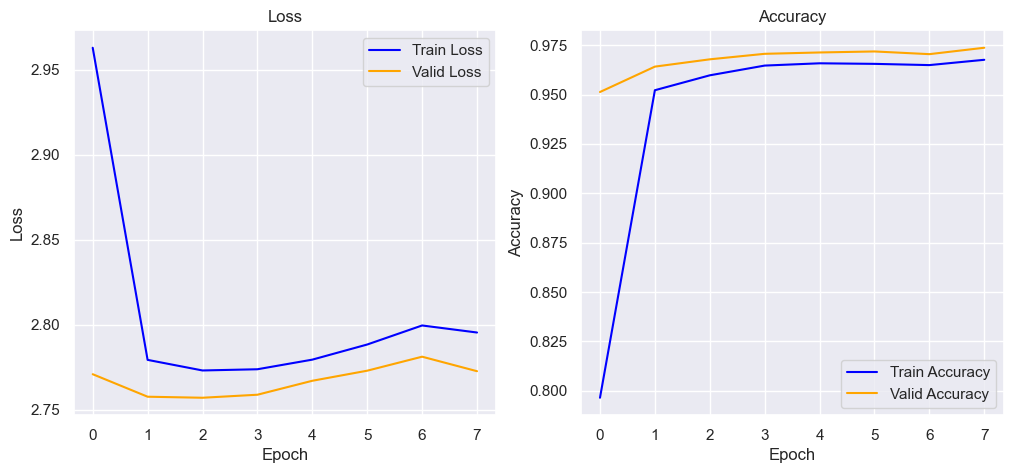

In [4]:
# MobileNetV2 in PyTorch
import os
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define paths
traindir = r"C:\Users\HP-OMEN\OneDrive\Desktop\crop disease\train"
validdir = r"C:\Users\HP-OMEN\OneDrive\Desktop\crop disease\valid"

# Image transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets with prefetching
train_dataset = datasets.ImageFolder(traindir, data_transforms['train'])
valid_dataset = datasets.ImageFolder(validdir, data_transforms['valid'])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

# Load MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier layer for our specific number of classes
num_classes = 38
model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 4096),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.BatchNorm1d(4096),
    nn.Linear(4096, num_classes),
    nn.Softmax(dim=1)
)

model = model.to(device)

# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier[1].parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train and evaluate function
def train_model(model, criterion, optimizer, scheduler, num_epochs=8):
    train_loss, valid_loss, train_acc, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            correct += torch.sum(preds == labels)
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct.double() / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc.cpu())

        # Validation phase
        model.eval()
        running_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                correct += torch.sum(preds == labels)
                total += labels.size(0)

        valid_loss_epoch = running_loss / len(valid_loader.dataset)
        valid_acc_epoch = correct.double() / total
        valid_loss.append(valid_loss_epoch)
        valid_acc.append(valid_acc_epoch.cpu())
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Valid Loss: {valid_loss_epoch:.4f} Acc: {valid_acc_epoch:.4f}')

        scheduler.step()

    return train_loss, valid_loss, train_acc, valid_acc

# Run training
train_loss, valid_loss, train_acc, valid_acc = train_model(model, criterion, optimizer, scheduler)


# Save the model weights
torch.save(model.state_dict(), "mobilenetv2_weights.pth")


# Plotting function
def plot_learning_curve(train_loss, valid_loss, train_acc, valid_acc):
    sns.set()
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, color='blue', label='Train Loss')
    plt.plot(valid_loss, color='orange', label='Valid Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, color='blue', label='Train Accuracy')
    plt.plot(valid_acc, color='orange', label='Valid Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

plot_learning_curve(train_loss, valid_loss, train_acc, valid_acc)
